<a href="https://colab.research.google.com/github/Takutino/AIT_finalProject_milestone/blob/main/AIT_project_milestone_takuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install needed files

In [1]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip

--2021-05-11 17:12:41--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.65.80, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M   158MB/s    in 0.4s    

2021-05-11 17:12:42 (158 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]



#### Unzip maestro midi files

In [2]:
!apt-get install unp
!unp maestro-v3.0.0-midi.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  xdms cabextract orange
The following NEW packages will be installed:
  unp
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 17.2 kB of archives.
After this operation, 136 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 unp all 2.0~pre7+nmu1 [17.2 kB]
Fetched 17.2 kB in 0s (73.6 kB/s)
Selecting previously unselected package unp.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../unp_2.0~pre7+nmu1_all.deb ...
Unpacking unp (2.0~pre7+nmu1) ...
Setting up unp (2.0~pre7+nmu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Archive:  maestro-v3.0.0-midi.zip
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_X

#### Install mido for working with MIDI messages and ports

In [3]:
!pip install mido

     |████████████████████████████████| 51kB 7.1MB/s 


#### Download the file which has all the meta information of midi files

In [4]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.csv

--2021-05-11 17:12:53--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298977 (292K) [application/octet-stream]
Saving to: ‘maestro-v3.0.0.csv’

maestro-v3.0.0.csv  100%[===================>] 291.97K  --.-KB/s    in 0.002s  

2021-05-11 17:12:53 (133 MB/s) - ‘maestro-v3.0.0.csv’ saved [298977/298977]



#### Read the csv file in the form of two dimensional datas
, which will be used for training, validation and testing

In [5]:
# source: https://github.com/DRyanMiller/MIDI_Visualization
import pandas as pd
# python package : working with panel datas : 2 dimensional data
files = pd.read_csv('https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.csv')
# will be using this for training and validation, and testing

#### Install Unidecode for encoding

In [6]:
# this is the one we are most likely to use
!pip install Unidecode

     |████████████████████████████████| 245kB 24.3MB/s 


### Read midi files and define some methods 
such as getting the max and min pitch of midi file and getting the time dimension for a pianoroll given a certain quantization


In [7]:
from mido import MidiFile
from unidecode import unidecode
import numpy as np

#######
# Pianorolls dims are  :   TIME  *  PITCH

#quantization : amplitude  resolution 
class Read_midi(object):
# initialize the some of properties
    def __init__(self, song_path, quantization):
        ## Metadata
        self.__song_path = song_path
        self.__quantization = quantization

        ## Pianoroll
        self.__T_pr = None

        ## Private misc
        self.__num_ticks = None
        self.__T_file = None

    @property
    def quantization(self):
        return self.__quantization

    @property
    def T_pr(self):
        return self.__T_pr

    @property
    def T_file(self):
        return self.__T_file

    def get_total_num_tick(self):
        # Midi length should be written in a meta message at the beginning of the file,
        # Read a midi file and return a dictionnary {track_name : pianoroll}
        mid = MidiFile(self.__song_path)

        # Parse track by track
        num_ticks = 0
        for i, track in enumerate(mid.tracks):
            tick_counter = 0
            for message in track:
                # Note on
                time = float(message.time)
                tick_counter += time
            num_ticks = max(num_ticks, tick_counter)
        self.__num_ticks = num_ticks

    # it finds the min and max pitch
    def get_pitch_range(self):
        mid = MidiFile(self.__song_path)
        min_pitch = 200
        max_pitch = 0
        for i, track in enumerate(mid.tracks):
            for message in track:
                if message.type in ['note_on', 'note_off']:
                    pitch = message.note
                    if pitch > max_pitch:
                        max_pitch = pitch
                    if pitch < min_pitch:
                        min_pitch = pitch
        return min_pitch, max_pitch
    
    def get_time_file(self):
        # Get the time dimension for a pianoroll given a certain quantization
        mid = MidiFile(self.__song_path)
        # Tick per beat
        ticks_per_beat = mid.ticks_per_beat
        # Total number of ticks
        self.get_total_num_tick()
        # Dimensions of the pianoroll for each track -> equation for getting the time
        self.__T_file = int((self.__num_ticks / ticks_per_beat) * self.__quantization)
        return self.__T_file

    # Read the actual data and read the score and tone
    def read_file(self):
        # Read the midi file and return a dictionnary {track_name : pianoroll}
        mid = MidiFile(self.__song_path)
        # Tick per beat
        ticks_per_beat = mid.ticks_per_beat

        # Get total time
        self.get_time_file()
        T_pr = self.__T_file
        #print("T_pr:", T_pr)
        # Pitch dimension
        N_pr = 128
        pianoroll = {}

        def add_note_to_pr(note_off, notes_on, pr):
            pitch_off, _, time_off = note_off
            # Note off : search for the note in the list of note on,
            # get the start and end time
            # write it in th pr
            match_list = [(ind, item) for (ind, item) in enumerate(notes_on) if item[0] == pitch_off]
            if len(match_list) == 0:
                print("Try to note off a note that has never been turned on")
                # Do nothing
                return

            # Add note to the pr
            pitch, velocity, time_on = match_list[0][1]
            pr[time_on:time_off, pitch] = velocity
            #v :  the force how strong you push the key
            #pr contains np array that has music data
            # Remove the note from notes_on
            ind_match = match_list[0][0]
            del notes_on[ind_match]
            return

        # Parse track by track
        counter_unnamed_track = 0
        #print("Number of tracks: ",mid.tracks)
        for i, track in enumerate(mid.tracks):
            # Instanciate the pianoroll
            pr = np.zeros([T_pr, N_pr])
            time_counter = 0
            notes_on = []
            for message in track:

                ##########################################
                ##########################################
                ##########################################
                # TODO : keep track of tempo information
                # import re
                # if re.search("tempo", message.type):
                #     import pdb; pdb.set_trace()
                ##########################################
                ##########################################
                ##########################################


                # print message
                # Time. Must be incremented, whether it is a note on/off or not
                time = float(message.time)
                time_counter += time / ticks_per_beat * self.__quantization
                # Time in pr (mapping)
                time_pr = int(round(time_counter))
                # Note on
                if message.type == 'note_on':
                    # Get pitch
                    pitch = message.note
                    # Get velocity
                    velocity = message.velocity
                    if velocity > 0:
                        notes_on.append((pitch, velocity, time_pr))
                    elif velocity == 0:
                        add_note_to_pr((pitch, velocity, time_pr), notes_on, pr)
                # Note off
                elif message.type == 'note_off':
                    pitch = message.note
                    velocity = message.velocity
                    add_note_to_pr((pitch, velocity, time_pr), notes_on, pr)

            # We deal with discrete values ranged between 0 and 127
            #     -> convert to int
            pr = pr.astype(np.int16)
            if np.sum(np.sum(pr)) > 0:
                name = unidecode(track.name)
                name = name.rstrip('\x00')
                if name == u'':
                    name = 'unnamed' + str(counter_unnamed_track)
                    counter_unnamed_track += 1
                if name in pianoroll.keys():
                    # Take max of the to pianorolls
                    pianoroll[name] = np.maximum(pr, pianoroll[name])
                else:
                    pianoroll[name] = pr
        return pianoroll

        #goal : return the np array : 2d matrices : time * pitch , assign values [velocity(loudness)]

import numpy as np

def get_pianoroll_time(pianoroll):
    T_pr_list = []
    for k, v in pianoroll.items():
        T_pr_list.append(v.shape[0])
    if not len(set(T_pr_list)) == 1:
        print("Inconsistent dimensions in the new PR")
        return None
    return T_pr_list[0]

def get_pitch_dim(pianoroll):
    N_pr_list = []
    for k, v in pianoroll.items():
        N_pr_list.append(v.shape[1])
    if not len(set(N_pr_list)) == 1:
        print("Inconsistent dimensions in the new PR")
        raise NameError("Pr dimension")
    return N_pr_list[0]

def dict_to_matrix(pianoroll):
    T_pr = get_pianoroll_time(pianoroll)
    N_pr = get_pitch_dim(pianoroll)
    rp = np.zeros((T_pr, N_pr), dtype=np.int16)
    for k, v in pianoroll.items():
        rp = np.maximum(rp, v)
    return rp

### Import python modules

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout, BatchNormalization
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns


### Go through all the midi files, load them onto numpy arrays split the data based on splic column of the datas

In [9]:
# go through all the midi files based on csv files

for i in range(1276):
  # files: that has the content of csv file
  # files[""] select the column of that data flame
  #.iloc selects the specific row
  file_path = "maestro-v3.0.0/"
  file_name = files["midi_filename"].iloc[i]
  file_type = files["split"].iloc[i]
  fileForOneRow = files.iloc[i]
  
  m = Read_midi(file_path+file_name, 4).read_file()
  # s =  Read_midi(file_path+file_name, 4).read_file()

  matrixBeforeSplit = dict_to_matrix(m)
  # if (file_type == "train") : 
  #     midi_train = dict_to_matrix(s)
  # elif (file_type == "validation") :
  #     midi_valid = dict_to_matrix(s)
  # else :
  #     midi_test = dict_to_matrix(s)

# print("For validation set")
# midi_valid.shape
# print("For all set")
# matrixBeforeSplit.shape
# print("For training set")
# midi_train.shape
# print("For test set", midi_test.shape)
# print("For validation set", midi_valid.shape)
# print("For train set", midi_train.shape)
# print("For train set", matrixBeforeSplit.shape)





Try to note off a note that has never been turned on


In [10]:
matrixBeforeSplit.shape

(5045, 128)

### Define the 1D convolutional neural network:

In [11]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_size, nb_input_series)))
    model.add(Dense(nb_outputs, activation='linear')) # pre - sigmoid
    model.compile(loss='mse', optimizer='adam')   #pre - binary-crossentropy
    return model

In [12]:
# def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
#     model = Sequential()
#     # model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='sigmoid', input_shape=(window_size, nb_input_series)))
#     # model.add(MaxPooling1D())
#     # model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='sigmoid'))
#     # model.add(MaxPooling1D())
#     # model.add(Flatten())
#     # model.compile(loss='mse', optimizer='adam') # pre - binary-crossentropy
#     return model

### Prepare for data

In [13]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

### Create the model, prepares the data, trains and evaluates the data:

In [14]:
from tensorflow.keras.callbacks import TensorBoard
tb = TensorBoard(log_dir='logs/baseline', histogram_freq=1, write_graph=1)

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=100,  restore_best_weights=True)

In [15]:
## This is something I wanted to try
def evaluate_timeseries_differently(timeseries, trainM, valM, testM, window_size, valid_split=0.15, test_split=0.15):
    filter_length = 5
    nb_filter = 4

    timeseries = np.atleast_2d(timeseries)
    trainM = np.atleast_2d(trainM)
    valM = np.atleast_2d(valM)
    testM = np.atleast_2d(testM)


    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix

    if valM.shape[0] == 1:
        valM = valM.T

    if trainM.shape[0] == 1:
        trainM = trainM.T

    if testM.shape[0] == 1:
        testM = testM.T

    nb_samples, nb_series = timeseries.shape
    model = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()
  
    # nb_samples_test, nb_series_test = testM.shape
    # model_test = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series_test, nb_outputs=nb_series_test, nb_filter=nb_filter)

    # nb_samples_val, nb_series_val = valM.shape
    # model_train = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series_val, nb_outputs=nb_series_val, nb_filter=nb_filter)

    # nb_samples_train, nb_series_train = trainM.shape
    # model_valid = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series_train, nb_outputs=nb_series_train, nb_filter=nb_filter)



    
    X, Y = make_timeseries_instances(timeseries, window_size)
    X_test, Y_test = make_timeseries_instances(testM, window_size)
    X_train, Y_train = make_timeseries_instances(trainM, window_size)
    X_valid, Y_valid = make_timeseries_instances(valM, window_size)
    
    # valid_size = int(nb_samples*(1-test_split-valid_split))
    # test_size = int(nb_samples*(1-test_split))
    # X_train, Y_train = X[:valid_size], Y[:valid_size]
    # X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    # X_test, Y_test   = X[test_size:], Y[test_size:]
    
    #modify Y_train, Y_valid, Y_test
    # Y_train[Y_train>1] = 1
    # Y_valid[Y_valid>1] = 1
    # Y_test[Y_test>1] = 1



    model.fit(X_train, Y_train, epochs=1000000, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2, callbacks=[tb,es])
    
    preds   = model.predict(X_test)

    return Y_test, preds   

In [16]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.15):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix
    nb_samples, nb_series = timeseries.shape
    model = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()

    
    X, Y = make_timeseries_instances(timeseries, window_size)
    
    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]
    
    #modify Y_train, Y_valid, Y_test
    # Y_train[Y_train>1] = 1
    # Y_valid[Y_valid>1] = 1
    # Y_test[Y_test>1] = 1



    model.fit(X_train, Y_train, epochs=1000000, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2, callbacks=[tb,es])
    
    preds   = model.predict(X_test)

    return Y_test, preds   

### Train and evaluate the model

In [17]:
window_size = 40
targets, preds = evaluate_timeseries(matrixBeforeSplit, window_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
Total params: 148,096
Trainable params: 148,096
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000000
221/221 - 35s - loss: 39.9899 - val_loss: 37.1926
Epoch 2/1000000
221/221 - 1s - loss: 36.8717 - val_loss: 35.1564
Epoch 3/1000000
221/221 - 1s - loss: 35.3255 - val_loss: 33.8911
Epoch 4/1000000
221/221 - 1s - loss: 34.1341 - val_loss: 33.0228
Epoch 5/1000000
221/221 - 1s - loss: 33.1638 - val_loss: 32.4520
Epoch 6/1000000
221/221 - 1s - loss: 32.2950 - val_loss: 32.1742
Epoch 7/1000000
221/221 - 1s - loss: 31.5201 - val_loss: 31.7300
Epoch 8/1000000
221/221 - 1s - loss: 30.8221 - val_loss:

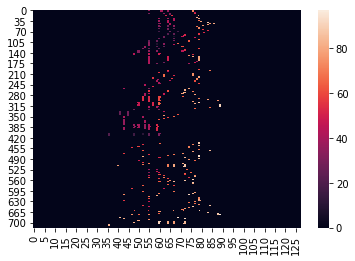

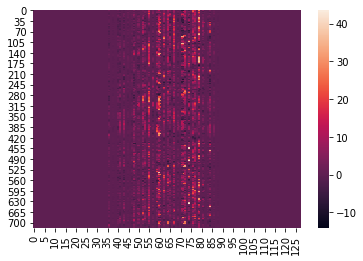

In [18]:
#Make the confusion matrix
#goal is to classify this correctly

import seaborn as sns

plt.figure()
sns.heatmap(targets)
plt.figure()
sns.heatmap(preds)


### Convert the output to the midi file

In [19]:
import os
from music21 import converter, instrument, note, chord, duration, stream

In [20]:
min_value = 0.00
lower_first = 0.00

lower_second = 0.5
upper_first = 0.5

upper_second = 1.0
max_value = 1.0

def int_to_note(integer):
    # Convert pitch value to the note which is a letter form. 
    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_detector = (integer // 12) 
    base_name_detector = (integer % 12) 
    note = note_base_name[base_name_detector] + str((int(octave_detector))-1)
    if ('-' in note):
      note = note_base_name[base_name_detector] + str(0)
      return note
    return note

# PAY ATTENTION. From matrix form to midi form, I have to indicate first touch, continuation and rest with unique numbers.
# I choose -1.0 for rest , 0 for continuation and 1 for first touch.

lower_bound = (lower_first + lower_second) / 2
upper_bound = (upper_first + upper_second) / 2

def converter_func(arr,first_touch = 1.0, continuation = 0.0, lower_bound = lower_bound, upper_bound = upper_bound):
    # First touch represent start for note, continuation represent continuation for first touch, 0 represent end or rest
    np.place(arr, arr < lower_bound, -1.0)
    np.place(arr, (lower_bound <= arr) & (arr < upper_bound), 0.0)
    np.place(arr, arr >= upper_bound, 1.0)
    return arr

def how_many_repetitive_func(array, from_where=0, continuation=0.0):
    new_array = array[from_where:]
    count_repetitive = 1 
    for i in new_array:
        if (i != continuation):
            return (count_repetitive)
        else:
            count_repetitive += 1
    return (count_repetitive)

In [21]:
def matrix_to_midi(matrix, random=0):
    first_touch = 1.0
    continuation = 0.0
    y_axis, x_axis = matrix.shape
    output_notes = []
    offset = 0
        
    # Delete rows until the row which include 'first_touch'
    how_many_in_start_zeros = 0
    for x_axis_num in range(x_axis):
        one_time_interval = matrix[:,x_axis_num] # Values in a column.
        one_time_interval_norm = converter_func(one_time_interval)
        if (first_touch not in one_time_interval_norm):
            how_many_in_start_zeros += 1
        else:
            break
            
    how_many_in_end_zeros = 0
    for x_axis_num in range(x_axis-1,0,-1):
        one_time_interval = matrix[:,x_axis_num] # values in a column
        one_time_interval_norm = converter_func(one_time_interval)
        if (first_touch not in one_time_interval_norm):
            how_many_in_end_zeros += 1
        else:
            break
        
    print ('How many rows for non-start note at beginning:', how_many_in_start_zeros)
    print ('How many rows for non-start note at end:', how_many_in_end_zeros)

    matrix = matrix[:,how_many_in_start_zeros:]
    y_axis, x_axis = matrix.shape
    print (y_axis, x_axis)

    for y_axis_num in range(y_axis):
        one_freq_interval = matrix[y_axis_num,:] # Values in a row.
        
        one_freq_interval_norm = converter_func(one_freq_interval)
        
        i = 0        
        offset = 0
        
        if (random):
          
          while (i < len(one_freq_interval)):
              how_many_repetitive = 0
              temp_i = i
              if (one_freq_interval_norm[i] == first_touch):
                  how_many_repetitive = how_many_repetitive_func(one_freq_interval_norm, from_where=i+1, continuation=continuation)
                  i += how_many_repetitive 

              if (how_many_repetitive > 0):
                  random_num = np.random.randint(3,6)
                  new_note = note.Note(int_to_note(y_axis_num),duration=duration.Duration(0.25*random_num*how_many_repetitive))
                  new_note.offset = 0.25*temp_i*2
                  new_note.storedInstrument = instrument.Piano()
                  output_notes.append(new_note)
              else:
                  i += 1
        
          
        else:
          
          while (i < len(one_freq_interval)):
              how_many_repetitive = 0
              temp_i = i
              if (one_freq_interval_norm[i] == first_touch):
                  how_many_repetitive = how_many_repetitive_func(one_freq_interval_norm, from_where=i+1, continuation=continuation)
                  i += how_many_repetitive 

              if (how_many_repetitive > 0):
                  new_note = note.Note(int_to_note(y_axis_num),duration=duration.Duration(0.25*how_many_repetitive))
                  new_note.offset = 0.25*temp_i
                  new_note.storedInstrument = instrument.Piano()
                  output_notes.append(new_note)
              else:
                   i += 1
        
    return output_notes

In [22]:
from google.colab import files

In [23]:
## For prediction
for temperature in [1.5]:
    print('------ temperature:', temperature)
    output_notes = matrix_to_midi(preds, random=1)
    midi_stream = stream.Stream(output_notes)
    midi_file_name = ('lstm_out_{}_{}.mid'.format("preds", temperature))
    midi_stream.write('midi', fp=midi_file_name)
    parsed = converter.parse(midi_file_name)
    for part in parsed.parts:
        part.insert(0, instrument.Piano())
    parsed.write('midi', fp=midi_file_name)

for file in os.listdir(os.getcwd()):
    if file.endswith(".mid"):
      files.download( file )


------ temperature: 1.5
How many rows for non-start note at beginning: 36
How many rows for non-start note at end: 39
717 92


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
## For targets
for temperature in [1.5]:
    print('------ temperature:', temperature)
    output_notes = matrix_to_midi(targets, random=1)
    midi_stream = stream.Stream(output_notes)
    midi_file_name = ('lstm_out_{}_{}.mid'.format("targets", temperature))
    midi_stream.write('midi', fp=midi_file_name)
    parsed = converter.parse(midi_file_name)
    for part in parsed.parts:
        part.insert(0, instrument.Piano())
    parsed.write('midi', fp=midi_file_name)

for file in os.listdir(os.getcwd()):
    if file.endswith(".mid"):
      files.download( file )

------ temperature: 1.5
How many rows for non-start note at beginning: 36
How many rows for non-start note at end: 38
717 92


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>